In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as VF
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

### The dataset used in the training is the blood cell data

In [2]:
# blood cell data file: https://www.kaggle.com/datasets/paultimothymooney/blood-cells  using dataset2-master
# from google.colab import files
# files.upload()

# or using an online zip from lazyprogrammer
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

File ‘blood_cell_images.zip’ already there; not retrieving.



In [3]:
# !unzip -nq dataset2-master.zip
!unzip -nq blood_cell_images.zip

In [4]:
# !ls dataset2-master/images
!ls blood_cell_images

TEST  TEST_SIMPLE  TRAIN


In [5]:
training_path = 'blood_cell_images/TRAIN'
testing_path = 'blood_cell_images/TEST'
evaling_path = 'blood_cell_images/TEST_SIMPLE'

In [6]:
training = glob(training_path+"/*/*.jp*g")
testing = glob(testing_path+"/*/*.jp*g")
evaling = glob(evaling_path+"/*/*.jp*g")

In [7]:
# The elements in training .etc are img paths
np.random.shuffle(training)
np.random.shuffle(testing)
np.random.shuffle(evaling)
training[0]

'blood_cell_images/TRAIN/NEUTROPHIL/_45_4472.jpeg'

torch.Size([3, 240, 320])


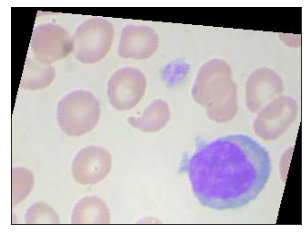

In [8]:
# show images
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

randimg = np.random.choice(training)
imgtensor = torchvision.io.read_image(randimg)
print(imgtensor.shape)
show([imgtensor])

In [9]:
randimg.split("/")

['blood_cell_images', 'TRAIN', 'LYMPHOCYTE', '_8_1855.jpeg']

In [10]:
labelMap = {"EOSINOPHIL":0, "LYMPHOCYTE":1, "MONOCYTE":2, "NEUTROPHIL":3}

class BloodCellDataset(Dataset):
    def __init__(self, img_catalog, transform=None, target_transform=None):
        self.img_catalog = img_catalog
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_catalog)

    def __getitem__(self, idx):
        img_path = self.img_catalog[idx]
        image = torchvision.io.read_image(img_path).float()
        image /= 127.5
        image -= 1.
        label = labelMap[img_path.split("/")[2]]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [11]:
cut = len(training)
train_data = BloodCellDataset(training[:cut])
test_data = BloodCellDataset(testing)
eval_data = BloodCellDataset(evaling)

In [12]:
len(train_data), len(test_data), len(eval_data)

(9957, 2487, 71)

In [13]:
K=4

## Forward Process

In [14]:
# define an identity block
class identity_block(nn.Module):
  def __init__(self, input_c, kernel_size, filters):
    super(identity_block, self).__init__()
    f1, f2, f3 = filters
    self.conv2d1 = nn.Conv2d(input_c,f1,1)
    self.bn1 = nn.BatchNorm2d(f1)

    self.conv2d2 = nn.Conv2d(f1,f2,kernel_size,padding='same')
    self.bn2 = nn.BatchNorm2d(f2)

    self.conv2d3 = nn.Conv2d(f2,f3,1)
    self.bn3 = nn.BatchNorm2d(f3)

    self.relu = nn.ReLU()

  def forward(self, input):
    x = self.conv2d1(input)
    x = self.relu(self.bn1(x))

    x = self.conv2d2(x)
    x = self.relu(self.bn2(x))

    x = self.conv2d3(x)
    x = self.relu(self.bn3(x + input))
    return x

In [15]:
# define an conv block
class conv_block(nn.Module):
  def __init__(self, input_c, kernel_size, filters, stride=2):
    super(conv_block, self).__init__()
    f1, f2, f3 = filters
    self.conv2d1 = nn.Conv2d(input_c,f1,1, stride=stride)
    self.bn1 = nn.BatchNorm2d(f1)

    self.conv2d2 = nn.Conv2d(f1,f2,kernel_size,padding='same')
    self.bn2 = nn.BatchNorm2d(f2)

    self.conv2d3 = nn.Conv2d(f2,f3,1)
    self.bn3 = nn.BatchNorm2d(f3)

    self.conv2d4 = nn.Conv2d(input_c,f3,1, stride=stride)

    self.relu = nn.ReLU()

  def forward(self, input):
    x = self.conv2d1(input)
    x = self.relu(self.bn1(x))

    x = self.conv2d2(x)
    x = self.relu(self.bn2(x))

    x = self.conv2d3(x)
    y = self.conv2d4(input)
    x = self.relu(self.bn3(x + y))
    return x

In [16]:
# ResNet
# The structure here is actually a mini sized version of the original ResNet

class ResNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.zeropad1 = nn.ZeroPad2d(3)
    self.conv1 = nn.Conv2d(3,32,7,2, padding='valid')
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,32,7,2, padding='valid')
    self.bn2 = nn.BatchNorm2d(32)

    self.zeropad2 = nn.ZeroPad2d(1)
    self.maxpool2 = nn.MaxPool2d(3, stride=2)

    self.convblock1 = conv_block(32, 3, [32, 32, 128], stride=1)
    self.idblock1 = identity_block(128, 3, [32, 32, 128])
    self.idblock2 = identity_block(128, 3, [32, 32, 128])

    self.convblock2 = conv_block(128, 3, [64, 64, 256], stride=1)
    self.idblock3 = identity_block(256, 3, [64, 64, 256])
    self.idblock4 = identity_block(256, 3, [64, 64, 256])
    self.idblock5 = identity_block(256, 3, [64, 64, 256])

    self.maxpool3 = nn.MaxPool2d(5, stride=5)
    self.flatten = nn.Flatten()
    self.linear = nn.Linear(8960, 4)
    self.softmax = nn.Softmax(dim=1)
    self.relu = nn.ReLU()

    pass
  def forward(self, input):
    t = self.zeropad1(input)
    t = self.conv1(t)
    t = self.bn1(t)
    t = self.relu(t)

    t = self.conv2(t)
    t = self.bn2(t)
    t = self.relu(t)

    t = self.zeropad2(t)
    t = self.maxpool2(t)

    t = self.convblock1(t)
    t = self.idblock1(t)
    t = self.idblock2(t)

    t = self.convblock2(t)
    t = self.idblock3(t)
    t = self.idblock4(t)
    t = self.idblock5(t)

    t = self.maxpool3(t)
    t = self.flatten(t)
    t = self.linear(t)
    t = self.softmax(t)

    return t

model = ResNet()
print(model)
if torch.cuda.is_available():
    model.cuda()

ResNet(
  (zeropad1): ZeroPad2d((3, 3, 3, 3))
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=valid)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(2, 2), padding=valid)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (zeropad2): ZeroPad2d((1, 1, 1, 1))
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock1): conv_block(
    (conv2d1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2d3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [17]:
# A reference model for comparison with ResNet

class RefCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.zeropad1 = nn.ZeroPad2d(3)
    self.conv1 = nn.Conv2d(3,32,7,2, padding='valid')
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32,8,7,2, padding='valid')
    self.bn2 = nn.BatchNorm2d(8)

    self.zeropad2 = nn.ZeroPad2d(1)
    self.maxpool2 = nn.MaxPool2d(3, stride=2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(8512, 4)
    self.softmax = nn.Softmax(dim=1)
    self.relu = nn.ReLU()

    pass
  def forward(self, input):
    t = self.zeropad1(input)
    t = self.conv1(t)
    t = self.relu(t)
    t = self.bn1(t)
    

    t = self.conv2(t)
    t = self.relu(t)
    t = self.bn2(t)

    # t = self.zeropad2(t)
    t = self.maxpool2(t)

    t = self.flatten(t)
    t = self.linear(t)
    t = self.softmax(t)

    return t

# model = RefCNN()
# print(model)
# if torch.cuda.is_available():
#     model.cuda()

In [18]:
epochs = 15
lr = 0.001
bs = 64
min_valid_loss = np.inf
loss_func = torch.nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
eval_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)

eval=True

for epoch in range(epochs):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = 0.0
    trainf1 = 0.0
    model.train()
    
    for i, data in tqdm(enumerate(train_dataloader)):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_func(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        cpreds = torch.argmax(preds.cpu().detach(), dim=1)
        f1score = f1_score(labels.cpu().detach().numpy(), cpreds.numpy(), average='weighted')
        trainf1 += np.sum(f1score)

    print(list(model.parameters())[0].grad[0][0])

    if eval==True:
        valid_loss = 0.0
        valf1 = 0.0
        model.eval()     # Optional when not using model Specific layer
        for i, data in enumerate(eval_dataloader):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels =inputs.cuda(), labels.cuda()
            preds = model(inputs)
            loss = loss_func(preds, labels)
            valid_loss += loss.item()
            cpreds = torch.argmax(preds.cpu().detach(), dim=1)
            f1score = f1_score(labels.cpu().detach().numpy(), cpreds.numpy(), average='weighted')
            valf1 += np.sum(f1score)

        if epoch%1==0:
            print(f'Epoch {epoch+1} \t Training Loss: {train_loss, train_loss / len(train_dataloader)} \t Training F1 Score: {trainf1, trainf1 / len(train_dataloader)}')
            print(f'\t Validation Loss: {valid_loss, valid_loss / len(eval_dataloader)}  \t Validation F1 Score: {valf1, valf1 / len(eval_dataloader)}')
        if min_valid_loss > valid_loss:
            print(f"Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})")
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')
    else:
        if epoch%1==0:
            print(f'Epoch {epoch+1} \t Training Loss: {train_loss, train_loss / len(train_dataloader)} \t Training F1 Score: {trainf1, trainf1 / len(train_dataloader)}')


156it [00:46,  3.32it/s]


tensor([[-2.0885e-04, -1.5818e-04, -2.0277e-04, -1.7060e-04, -1.3958e-04,
         -5.8663e-05, -2.8880e-05],
        [-2.6386e-04, -2.1338e-04, -1.9234e-04, -1.5362e-04, -1.0870e-04,
         -5.2647e-05, -7.5428e-06],
        [-1.9058e-04, -1.6733e-04, -1.3314e-04, -8.7017e-05, -3.5784e-05,
          2.5215e-05,  5.3620e-05],
        [-4.5635e-05, -2.2155e-05, -1.3848e-05,  3.0975e-05,  9.1680e-05,
          1.5498e-04,  2.0294e-04],
        [-3.2132e-05,  2.6645e-06,  2.5299e-05,  9.7203e-05,  1.3518e-04,
          1.8882e-04,  2.5662e-04],
        [ 2.3076e-05,  4.1909e-05,  7.1801e-05,  1.4196e-04,  1.8284e-04,
          2.3265e-04,  2.6215e-04],
        [ 8.3060e-05,  1.0031e-04,  1.4337e-04,  1.9524e-04,  2.2764e-04,
          2.6967e-04,  3.4509e-04]], device='cuda:0')
Epoch 1 	 Training Loss: (227.3858267068863, 1.4576014532492712) 	 Training F1 Score: (32.50392501581521, 0.20835849369112316)
	 Validation Loss: (59.12238073348999, 1.5159584803458972)  	 Validation F1 Score: (6

156it [00:42,  3.64it/s]


tensor([[-0.0131, -0.0129, -0.0128, -0.0118, -0.0108, -0.0099, -0.0100],
        [-0.0121, -0.0119, -0.0117, -0.0110, -0.0098, -0.0090, -0.0093],
        [-0.0108, -0.0108, -0.0107, -0.0099, -0.0090, -0.0082, -0.0083],
        [-0.0093, -0.0092, -0.0093, -0.0085, -0.0080, -0.0075, -0.0079],
        [-0.0079, -0.0077, -0.0078, -0.0071, -0.0068, -0.0064, -0.0070],
        [-0.0065, -0.0065, -0.0065, -0.0058, -0.0054, -0.0052, -0.0056],
        [-0.0050, -0.0050, -0.0047, -0.0039, -0.0038, -0.0034, -0.0038]],
       device='cuda:0')
Epoch 2 	 Training Loss: (181.1280658841133, 1.1610773454109828) 	 Training F1 Score: (84.64585835229495, 0.5426016561044548)
	 Validation Loss: (51.83310890197754, 1.3290540744096806)  	 Validation F1 Score: (13.366649300560292, 0.3427345974502639)
Validation Loss Decreased(59.122381--->51.833109)


156it [00:42,  3.67it/s]


tensor([[-5.5504e-03, -5.5049e-03, -5.9537e-03, -6.5454e-03, -7.0533e-03,
         -6.9017e-03, -6.5441e-03],
        [-3.8619e-03, -4.3443e-03, -4.5056e-03, -5.4899e-03, -5.9003e-03,
         -6.1679e-03, -5.5525e-03],
        [-1.9054e-03, -2.0580e-03, -2.2828e-03, -3.2259e-03, -3.8114e-03,
         -4.1185e-03, -3.9220e-03],
        [-6.3374e-04, -6.5189e-04, -3.3909e-04, -1.2440e-03, -1.6719e-03,
         -2.4977e-03, -2.3396e-03],
        [ 1.0212e-03,  9.3144e-04,  1.3135e-03,  4.6912e-04, -8.5145e-05,
         -6.8483e-04, -1.1819e-04],
        [ 2.4383e-03,  2.1779e-03,  2.6780e-03,  1.9804e-03,  1.6101e-03,
          9.7662e-04,  1.4092e-03],
        [ 2.7829e-03,  2.9272e-03,  3.3879e-03,  2.9087e-03,  2.7587e-03,
          2.2384e-03,  2.7208e-03]], device='cuda:0')
Epoch 3 	 Training Loss: (143.0121619105339, 0.9167446276316276) 	 Training F1 Score: (128.53496715971906, 0.8239420971776863)
	 Validation Loss: (36.810195565223694, 0.9438511683390691)  	 Validation F1 Score: (

156it [00:41,  3.72it/s]


tensor([[0.0079, 0.0079, 0.0079, 0.0075, 0.0074, 0.0069, 0.0066],
        [0.0083, 0.0084, 0.0084, 0.0080, 0.0078, 0.0074, 0.0071],
        [0.0088, 0.0089, 0.0088, 0.0083, 0.0082, 0.0077, 0.0074],
        [0.0094, 0.0096, 0.0097, 0.0092, 0.0091, 0.0086, 0.0084],
        [0.0098, 0.0100, 0.0102, 0.0097, 0.0097, 0.0093, 0.0092],
        [0.0103, 0.0105, 0.0107, 0.0103, 0.0104, 0.0100, 0.0100],
        [0.0106, 0.0108, 0.0110, 0.0106, 0.0108, 0.0103, 0.0103]],
       device='cuda:0')
Epoch 4 	 Training Loss: (137.02730625867844, 0.8783801683248618) 	 Training F1 Score: (134.95918442886418, 0.8651229771081037)
	 Validation Loss: (37.50005227327347, 0.9615398018788068)  	 Validation F1 Score: (30.252350498389045, 0.7757012948304883)


156it [00:41,  3.72it/s]


tensor([[0.0127, 0.0132, 0.0136, 0.0141, 0.0143, 0.0145, 0.0139],
        [0.0117, 0.0122, 0.0126, 0.0132, 0.0136, 0.0139, 0.0133],
        [0.0112, 0.0115, 0.0117, 0.0128, 0.0133, 0.0136, 0.0129],
        [0.0107, 0.0108, 0.0113, 0.0120, 0.0128, 0.0131, 0.0127],
        [0.0106, 0.0105, 0.0109, 0.0116, 0.0122, 0.0125, 0.0121],
        [0.0105, 0.0103, 0.0107, 0.0111, 0.0118, 0.0119, 0.0117],
        [0.0103, 0.0100, 0.0103, 0.0106, 0.0111, 0.0110, 0.0106]],
       device='cuda:0')
Epoch 5 	 Training Loss: (132.2411608695984, 0.8476997491640922) 	 Training F1 Score: (139.78864950944163, 0.8960810865989848)
	 Validation Loss: (40.62263071537018, 1.0416059157787225)  	 Validation F1 Score: (27.488084957650845, 0.7048226912218165)


156it [00:41,  3.72it/s]


tensor([[ 1.5407e-03,  1.7839e-03,  1.3577e-03,  1.1524e-03,  4.4860e-04,
         -4.8800e-05, -6.0690e-04],
        [ 1.5841e-03,  1.8072e-03,  1.3930e-03,  1.1834e-03,  4.9224e-04,
         -3.2752e-05, -5.2855e-04],
        [ 1.5358e-03,  1.6506e-03,  1.1941e-03,  8.3471e-04,  8.6898e-05,
         -4.1736e-04, -9.0361e-04],
        [ 1.4222e-03,  1.5128e-03,  1.1033e-03,  7.6523e-04,  1.7893e-05,
         -4.1126e-04, -8.3564e-04],
        [ 1.2229e-03,  1.1956e-03,  8.0778e-04,  4.0999e-04, -3.5304e-04,
         -7.7623e-04, -1.2063e-03],
        [ 9.1949e-04,  8.5570e-04,  4.0759e-04,  1.2044e-04, -4.7534e-04,
         -7.8633e-04, -1.2457e-03],
        [ 7.1481e-04,  5.4185e-04,  1.7203e-04, -5.2652e-05, -6.4555e-04,
         -9.7200e-04, -1.3789e-03]], device='cuda:0')
Epoch 6 	 Training Loss: (128.05538094043732, 0.8208678265412649) 	 Training F1 Score: (143.92351704982872, 0.9225866477553123)
	 Validation Loss: (36.65511202812195, 0.9398746673877423)  	 Validation F1 Score: (

156it [00:43,  3.60it/s]


tensor([[-0.0116, -0.0112, -0.0112, -0.0110, -0.0106, -0.0102, -0.0099],
        [-0.0110, -0.0105, -0.0105, -0.0103, -0.0098, -0.0094, -0.0093],
        [-0.0107, -0.0103, -0.0102, -0.0099, -0.0094, -0.0090, -0.0088],
        [-0.0100, -0.0097, -0.0094, -0.0093, -0.0088, -0.0085, -0.0084],
        [-0.0096, -0.0093, -0.0090, -0.0089, -0.0084, -0.0082, -0.0081],
        [-0.0085, -0.0082, -0.0080, -0.0078, -0.0075, -0.0072, -0.0072],
        [-0.0079, -0.0076, -0.0074, -0.0071, -0.0069, -0.0064, -0.0064]],
       device='cuda:0')
Epoch 7 	 Training Loss: (127.54174798727036, 0.8175753076107074) 	 Training F1 Score: (144.42747947706914, 0.9258171761350587)
	 Validation Loss: (46.84113311767578, 1.20105469532502)  	 Validation F1 Score: (17.78983990503001, 0.45614974115461565)


156it [00:43,  3.59it/s]


tensor([[-0.0027, -0.0024, -0.0026, -0.0029, -0.0031, -0.0031, -0.0031],
        [-0.0026, -0.0024, -0.0026, -0.0029, -0.0033, -0.0032, -0.0032],
        [-0.0025, -0.0023, -0.0026, -0.0030, -0.0034, -0.0034, -0.0034],
        [-0.0021, -0.0020, -0.0022, -0.0026, -0.0029, -0.0029, -0.0029],
        [-0.0018, -0.0015, -0.0016, -0.0020, -0.0023, -0.0024, -0.0024],
        [-0.0012, -0.0010, -0.0011, -0.0014, -0.0017, -0.0018, -0.0018],
        [-0.0008, -0.0005, -0.0006, -0.0010, -0.0012, -0.0014, -0.0015]],
       device='cuda:0')
Epoch 8 	 Training Loss: (127.34617358446121, 0.8163216255414181) 	 Training F1 Score: (144.76420760270523, 0.9279756897609309)
	 Validation Loss: (36.88896977901459, 0.945871019974733)  	 Validation F1 Score: (31.380280180459646, 0.8046225687297345)


156it [00:45,  3.43it/s]


tensor([[0.0014, 0.0017, 0.0018, 0.0019, 0.0020, 0.0022, 0.0024],
        [0.0011, 0.0013, 0.0014, 0.0015, 0.0017, 0.0020, 0.0023],
        [0.0011, 0.0013, 0.0013, 0.0013, 0.0014, 0.0017, 0.0020],
        [0.0012, 0.0013, 0.0014, 0.0014, 0.0015, 0.0018, 0.0021],
        [0.0014, 0.0015, 0.0017, 0.0017, 0.0018, 0.0020, 0.0024],
        [0.0016, 0.0018, 0.0020, 0.0020, 0.0021, 0.0023, 0.0026],
        [0.0018, 0.0020, 0.0023, 0.0023, 0.0024, 0.0025, 0.0028]],
       device='cuda:0')
Epoch 9 	 Training Loss: (127.21229803562164, 0.8154634489462926) 	 Training F1 Score: (144.61764953953855, 0.9270362149970419)
	 Validation Loss: (35.031556129455566, 0.8982450289603992)  	 Validation F1 Score: (32.8057093752913, 0.8411720352638795)
Validation Loss Decreased(36.655112--->35.031556)


156it [00:42,  3.65it/s]


tensor([[ 1.3680e-04, -6.9066e-05, -1.1043e-04, -8.2006e-05, -6.4749e-05,
          2.6954e-05,  1.3443e-05],
        [-9.7422e-05, -2.6462e-04, -3.3446e-04, -3.2186e-04, -2.6685e-04,
         -1.4936e-04, -1.0768e-04],
        [-1.8575e-04, -3.9735e-04, -4.8395e-04, -5.0161e-04, -4.6816e-04,
         -3.5847e-04, -2.9043e-04],
        [-2.8330e-04, -5.5193e-04, -6.4985e-04, -7.1801e-04, -6.7615e-04,
         -5.5400e-04, -4.4816e-04],
        [-2.7843e-04, -5.1960e-04, -6.3276e-04, -7.1024e-04, -6.5914e-04,
         -5.4150e-04, -4.2368e-04],
        [-1.9340e-04, -4.4449e-04, -5.6621e-04, -6.7784e-04, -5.9905e-04,
         -4.9165e-04, -3.2816e-04],
        [-7.6759e-05, -3.1460e-04, -4.1954e-04, -5.2257e-04, -4.7982e-04,
         -3.3704e-04, -1.8889e-04]], device='cuda:0')
Epoch 10 	 Training Loss: (125.83322542905807, 0.8066232399298594) 	 Training F1 Score: (146.20714603832073, 0.9372252951174406)
	 Validation Loss: (34.84691399335861, 0.8935106152143234)  	 Validation F1 Score: 

156it [00:42,  3.66it/s]


tensor([[-0.0199, -0.0201, -0.0204, -0.0203, -0.0204, -0.0201, -0.0200],
        [-0.0198, -0.0201, -0.0203, -0.0202, -0.0202, -0.0198, -0.0196],
        [-0.0197, -0.0200, -0.0202, -0.0201, -0.0201, -0.0197, -0.0194],
        [-0.0179, -0.0182, -0.0182, -0.0182, -0.0182, -0.0179, -0.0177],
        [-0.0177, -0.0180, -0.0181, -0.0181, -0.0180, -0.0177, -0.0176],
        [-0.0173, -0.0177, -0.0177, -0.0178, -0.0177, -0.0175, -0.0173],
        [-0.0172, -0.0176, -0.0176, -0.0177, -0.0177, -0.0173, -0.0172]],
       device='cuda:0')
Epoch 11 	 Training Loss: (124.5925720334053, 0.7986703335474699) 	 Training F1 Score: (147.36535349322077, 0.9446497018796203)
	 Validation Loss: (34.57638335227966, 0.8865739321097349)  	 Validation F1 Score: (33.49938469128752, 0.8589585818278851)
Validation Loss Decreased(34.846914--->34.576383)


156it [00:42,  3.69it/s]


tensor([[-0.0071, -0.0072, -0.0075, -0.0076, -0.0080, -0.0080, -0.0084],
        [-0.0069, -0.0068, -0.0070, -0.0070, -0.0073, -0.0073, -0.0076],
        [-0.0071, -0.0068, -0.0071, -0.0070, -0.0072, -0.0070, -0.0071],
        [-0.0070, -0.0068, -0.0068, -0.0067, -0.0067, -0.0064, -0.0065],
        [-0.0069, -0.0066, -0.0066, -0.0065, -0.0066, -0.0062, -0.0061],
        [-0.0064, -0.0061, -0.0060, -0.0058, -0.0057, -0.0054, -0.0053],
        [-0.0061, -0.0057, -0.0056, -0.0053, -0.0052, -0.0048, -0.0046]],
       device='cuda:0')
Epoch 12 	 Training Loss: (124.89275389909744, 0.8005945762762656) 	 Training F1 Score: (147.2067859250526, 0.9436332431093115)
	 Validation Loss: (37.11057251691818, 0.9515531414594406)  	 Validation F1 Score: (30.42294150221594, 0.7800754231337421)


156it [00:42,  3.71it/s]


tensor([[ 2.2635e-04,  2.0142e-04,  1.7224e-04,  1.4542e-04,  1.1813e-04,
          9.4767e-05,  6.8960e-05],
        [ 2.1686e-04,  1.7765e-04,  1.4825e-04,  1.1536e-04,  9.0110e-05,
          5.9572e-05,  4.1039e-05],
        [ 1.9558e-04,  1.6092e-04,  1.1750e-04,  8.5725e-05,  5.1377e-05,
          2.5770e-05, -7.4781e-06],
        [ 1.5818e-04,  1.1366e-04,  6.4535e-05,  2.7187e-05, -7.0527e-06,
         -4.1769e-05, -6.8622e-05],
        [ 1.2768e-04,  7.8219e-05,  2.3322e-05, -2.3100e-05, -6.0351e-05,
         -9.5094e-05, -1.2323e-04],
        [ 9.2392e-05,  2.9631e-05, -2.3590e-05, -7.7031e-05, -1.0950e-04,
         -1.5369e-04, -1.7172e-04],
        [ 6.2332e-05, -9.0676e-07, -5.8575e-05, -1.1945e-04, -1.4940e-04,
         -1.9028e-04, -2.1206e-04]], device='cuda:0')
Epoch 13 	 Training Loss: (125.72335720062256, 0.8059189564142472) 	 Training F1 Score: (146.19350378124062, 0.9371378447515425)
	 Validation Loss: (34.07614779472351, 0.8737473793518848)  	 Validation F1 Score: 

156it [00:42,  3.68it/s]


tensor([[3.9506e-05, 3.9961e-05, 3.9546e-05, 4.2474e-05, 4.6258e-05, 5.7633e-05,
         6.3881e-05],
        [5.4064e-05, 5.2488e-05, 5.0605e-05, 5.3718e-05, 5.8689e-05, 7.2670e-05,
         8.1126e-05],
        [6.7930e-05, 6.2548e-05, 6.1357e-05, 6.3966e-05, 6.9344e-05, 8.6024e-05,
         9.6948e-05],
        [8.8172e-05, 8.0460e-05, 7.9531e-05, 8.0805e-05, 9.0239e-05, 1.0887e-04,
         1.2489e-04],
        [9.6969e-05, 9.1734e-05, 9.3634e-05, 9.8573e-05, 1.0944e-04, 1.3053e-04,
         1.4670e-04],
        [1.2362e-04, 1.1814e-04, 1.2188e-04, 1.3020e-04, 1.4669e-04, 1.6645e-04,
         1.9056e-04],
        [1.4633e-04, 1.4668e-04, 1.5205e-04, 1.6170e-04, 1.7616e-04, 1.9847e-04,
         2.1686e-04]], device='cuda:0')
Epoch 14 	 Training Loss: (124.31936013698578, 0.7969189752370883) 	 Training F1 Score: (147.65194881809364, 0.9464868513980361)
	 Validation Loss: (34.33486878871918, 0.8803812509927994)  	 Validation F1 Score: (33.74298678014235, 0.8652047892344193)


156it [00:42,  3.70it/s]


tensor([[-0.0029, -0.0029, -0.0025, -0.0022, -0.0017, -0.0015, -0.0011],
        [-0.0032, -0.0031, -0.0029, -0.0026, -0.0023, -0.0020, -0.0018],
        [-0.0033, -0.0034, -0.0032, -0.0031, -0.0027, -0.0026, -0.0021],
        [-0.0037, -0.0038, -0.0038, -0.0037, -0.0035, -0.0033, -0.0030],
        [-0.0031, -0.0037, -0.0037, -0.0039, -0.0036, -0.0035, -0.0031],
        [-0.0026, -0.0030, -0.0034, -0.0035, -0.0036, -0.0035, -0.0033],
        [-0.0013, -0.0020, -0.0022, -0.0026, -0.0025, -0.0028, -0.0025]],
       device='cuda:0')
Epoch 15 	 Training Loss: (124.57162487506866, 0.7985360568914658) 	 Training F1 Score: (147.38825323250842, 0.9447964950801822)
	 Validation Loss: (34.27369421720505, 0.8788126722360269)  	 Validation F1 Score: (33.707682976066806, 0.8642995634888925)


In [19]:

test_loss = 0
testf1 = 0
model.eval()
for i, data in enumerate(test_dataloader):
    inputs, labels = data
    if torch.cuda.is_available():
        inputs, labels =inputs.cuda(), labels.cuda()
    preds = model(inputs)
    loss = loss_func(preds, labels)
    test_loss += loss.item()
    cpreds = torch.argmax(preds.cpu().detach(), dim=1)
    f1score = f1_score(labels.cpu().detach().numpy(), cpreds.numpy(), average='weighted')
    testf1 += np.sum(f1score)

print(f'\t Validation Loss: {test_loss, test_loss / len(test_dataloader)}  \t Validation F1 Score: {testf1, testf1 / len(test_dataloader)}')

	 Validation Loss: (34.277667582035065, 0.8789145533855145)  	 Validation F1 Score: (33.70089984507237, 0.8641256370531377)


In [20]:
# torch.cuda.empty_cache()